In [1]:
from submissions.ab_submission.dataLoaders import imageDataLoader
from submissions.ab_submission.object_detector import ObjectDetector
from submissions.ab_submission import dataset

import importlib

importlib.reload(dataset)

<module 'submissions.ab_submission.dataset' from '/home/ali/git/follicles_detection/submissions/ab_submission/dataset.py'>

# Model evaluation

In [2]:
import glob
import pandas as pd

In [3]:
train_files = glob.glob("./data/train/*.jpg")
test_files = glob.glob("./data/test/*.jpg")
train_label = pd.read_csv("./data/train/labels.csv")
test_label = pd.read_csv("./data/test/labels.csv")

In [4]:
model = ObjectDetector(ramp_mode=False)
model.load(boxPixelClassifier="./params/boxPixelClassifier_opencv.joblib", follicleClassifier="./params/follicleClassifier2.model")
model.fit(train_files, train_label)
#model.save(boxPixelClassifier="./params/boxPixelClassifier_opencv.joblib",follicleClassifier="./params/follicleClassifier2.model")

Fitting boxPixelClassifier
Fitting follicleClassifier
Model save in ./params/follicleClassifier2.model


In [5]:
y_hat = model.predict(test_files)

In [6]:
import numpy as np
import glob
import os
import pandas as pd
from matplotlib import pyplot as plt

from PIL import Image, ImageDraw, ImageFont

font_size = 60
if os.name != 'nt':
    font = ImageFont.truetype("/usr/share/fonts/truetype/freefont/FreeMono.ttf", font_size)
else:
    font = ImageFont.truetype("C:/Windows/Fonts/Arial/arialbd.ttf", font_size)

def write_rectangle(image, preds, folder=None, filename=None):
    img = Image.fromarray(image)
    img_draw = ImageDraw.Draw(img)
    for pred in preds:
        x1, y1, x2, y2 = pred["bbox"]
        label = pred["class"]
        img_draw.rounded_rectangle(((x1, y1), (x2,y2)), fill=None, outline="black", width=5)
        img_draw.text((x1, y1-70), label, font=font, fill="black")

    if folder is not None and filename is not None:
        img.save(f"./data/{folder}/{filename}")
    
    return np.array(img)

In [6]:
test_loader = imageDataLoader(test_files, test_label[["filename","xmin","xmax","ymin","ymax","label"]])
train_loader = imageDataLoader(train_files, train_label[["filename","xmin","xmax","ymin","ymax","label"]])
predict_loader = imageDataLoader(test_files, None)

In [18]:
for data, preds, filename in zip(test_loader.get_samples(), y_hat, test_loader.X_filenames):
    write_rectangle(data[0], preds, "test_predicted", filename)

In [10]:
reload_data = False

train_dataset = dataset.folliclesDataset(
    train_loader,
    data_augmentation=False,
    local_path="./datasets/train",
    box_classifier=model._get_box_list,
    verbose=False,
    order="box_ratio",
    force_reload=reload_data,
    mode="all"
)

test_dataset = dataset.folliclesDataset(
    test_loader,
    data_augmentation=False,
    local_path="./datasets/test",
    box_classifier=model._get_box_list,
    verbose=False,
    order="box_ratio",
    force_reload=reload_data,
    mode="crop"
)

In [12]:
from torchvision.transforms import Resize, Pad, RandomHorizontalFlip, RandomVerticalFlip
from torch import nn
import torch



In [13]:
for x in test_loader.get_samples():
    break

In [15]:
import cv2

In [81]:
dataloader_collapse

In [19]:
from torch.utils.data import DataLoader
dataloader_collapse_test = lambda x: dataset.dataloader_collapse(x, image_size_width=128, reducer="resize", random_flip=True)
dataloader_collapse_train = lambda x: dataset.dataloader_collapse(x, image_size_width=128, reducer="resize", random_flip=False)

test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=dataloader_collapse_test)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False, collate_fn=dataloader_collapse_train)

In [20]:
from submissions.ab_submission import follicleClassifier
import importlib

importlib.reload(follicleClassifier)

<module 'submissions.ab_submission.follicleClassifier' from '/home/ali/git/follicles_detection/submissions/ab_submission/follicleClassifier.py'>

In [82]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

def plot_cm (y, y_hat):

    cm = confusion_matrix(y, y_hat)
    cm_plot = ConfusionMatrixDisplay(cm)

    cm_plot.plot()

In [268]:
n_epoch = 100
model_cnn = follicleClassifier.follicleClassifier()
model_cnn.to("cuda:0")

for i in range(n_epoch):
    print(f"Epoch : {i}")
    for x, y in train_dataloader:
        
        x = x.to("cuda:0")
        y = y.to("cuda:0")

        model_cnn.fit(x,y)

    print(f"Loss function : {np.array(model_cnn.losses).mean()}")

Epoch : 0
Loss function : 1.6891252483640398
Epoch : 1
Loss function : 1.6628476920581998
Epoch : 2
Loss function : 1.6289740498103793
Epoch : 3
Loss function : 1.5894577020690555
Epoch : 4
Loss function : 1.5477314744676862
Epoch : 5
Loss function : 1.5076821105820792
Epoch : 6
Loss function : 1.4712161985384364
Epoch : 7
Loss function : 1.4384482403596242
Epoch : 8
Loss function : 1.4092471908639979
Epoch : 9
Loss function : 1.3828192296482267
Epoch : 10
Loss function : 1.360013045273818
Epoch : 11
Loss function : 1.3399646206507607
Epoch : 12
Loss function : 1.3214997013846597
Epoch : 13
Loss function : 1.3049444276459363
Epoch : 14
Loss function : 1.2897339154803564
Epoch : 15
Loss function : 1.2762897027035554
Epoch : 16
Loss function : 1.2643827532185894
Epoch : 17
Loss function : 1.2531754793944183
Epoch : 18
Loss function : 1.2423683968104218
Epoch : 19
Loss function : 1.2328991824672335
Epoch : 20
Loss function : 1.2239392595766894
Epoch : 21
Loss function : 1.2159284029430124

In [269]:
y_hats = []
ys = []

for x,y in train_dataloader:
    x = x.to("cuda:0")
    y_hat = model_cnn.predict(x)
    y_hats.append(y_hat)
    ys.append(y)

y_hats = torch.concat(y_hats)
ys = torch.concat(ys)

y_hats_class = torch.argmax(y_hats, dim=1).to("cpu").numpy()
ys_class = torch.argmax(ys, dim=1).to("cpu").numpy()

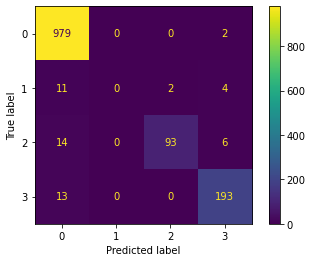

In [270]:
plot_cm(ys_class, y_hats_class)

In [271]:
y_hats = []
ys = []

for x,y in test_dataloader:
    x = x.to("cuda:0")
    y_hat = model_cnn.predict(x)
    y_hats.append(y_hat)
    ys.append(y)

y_hats = torch.concat(y_hats)
ys = torch.concat(ys)

y_hats_class = torch.argmax(y_hats, dim=1).to("cpu").numpy()
ys_class = torch.argmax(ys, dim=1).to("cpu").numpy()

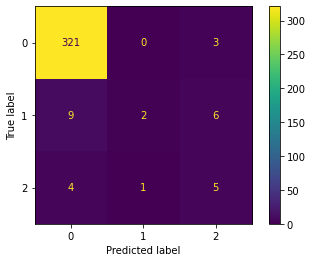

In [272]:
plot_cm(ys_class, y_hats_class)

In [273]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV

In [274]:
xs = []
ys = []

with torch.no_grad():
    model_cnn.eval()

    for x, y in train_dataloader:
        ys.append(y)

        x = x.to("cuda:0")
        x_hat_intermediate = model_cnn.network[0:9](x)

        xs.append(x_hat_intermediate.cpu().numpy())

x_ds = np.concatenate(xs)
y_ds = np.concatenate(ys)

In [275]:
distance_to_border = np.array([
    np.array([0.5*(train_dataset.metadata[x]["bbox"][0]+train_dataset.metadata[x]["bbox"][2])/train_dataset.metadata[x]["width"], 0.5*(train_dataset.metadata[x]["bbox"][1]+train_dataset.metadata[x]["bbox"][3])/train_dataset.metadata[x]["height"]])
    for x in train_dataset.metadata_mask.values()
])

x_ds = np.concatenate([distance_to_border, x_ds], axis=1)

In [276]:
rf = RandomForestClassifier(n_estimators=200, max_depth=20, class_weight="balanced")
rf.fit(x_ds, y_ds)

RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=200)

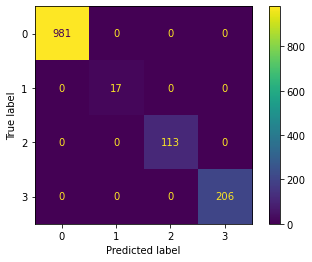

In [277]:
plot_cm(np.argmax(y_ds, axis=1), np.argmax(rf.predict(x_ds), axis=1))

In [278]:
xs = []
ys = []

with torch.no_grad():
    model_cnn.eval()

    for x, y in test_dataloader:
        ys.append(y)

        x = x.to("cuda:0")
        x_hat_intermediate = model_cnn.network[0:9](x)

        xs.append(x_hat_intermediate.cpu().numpy())

x_ds = np.concatenate(xs)
y_ds = np.concatenate(ys)

In [279]:
distance_to_border = np.array([
    np.array([0.5*(test_dataset.metadata[x]["bbox"][0]+test_dataset.metadata[x]["bbox"][2])/test_dataset.metadata[x]["width"], 0.5*(test_dataset.metadata[x]["bbox"][1]+test_dataset.metadata[x]["bbox"][3])/test_dataset.metadata[x]["height"]])
    for x in test_dataset.metadata_mask.values()
])

x_ds = np.concatenate([distance_to_border, x_ds], axis=1)

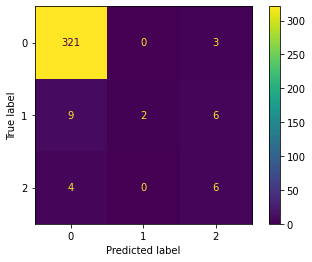

In [280]:
plot_cm(np.argmax(y_ds, axis=1), np.argmax(rf.predict(x_ds), axis=1))

In [99]:
f1_score(ys_class, y_hats_class, average="macro")

0.5790494058786742

In [100]:
f1_score(ys_class, y_hats_class, average="micro")

0.9373219373219374